## Temperature Stabilized Measurements - 30°C, 0.5 g/L Starch, 1 g/L Starch, H2O without Particles

### Loading the Libraries

In [180]:
import os
#import earthpy as et
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import scipy as sp
import statsmodels.formula.api as smf

import matplotlib.colors as col


import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing
import pandas
from sklearn import tree
#import pydotplus
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import matplotlib.image as pltimg

from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import linear_model, tree, ensemble
#pd.options.plotting.backend = "matplotlib" #Abändern des Plot Backends
pd.options.plotting.backend = "plotly"
#pd.options.mode.use_inf_as_na = True

In [181]:
import sys
print(sys.platform)
print(os.listdir())
if sys.platform.startswith('linux'):
    # Linux specific procedures
    df_H2O = pd.read_csv(r"technology/experiments/sonicMeasure/Pretests/data/RunsTControlled/sonicMeasureRunData10_H2O_2021-06-22.csv", sep=",")
    df_starch_05 = pd.read_csv(r"technology/experiments/sonicMeasure/Pretests/data/RunsTControlled/sonicMeasureRunData10_starch0.5gL.csv", sep=",")
    df_starch_10 = pd.read_csv(r"technology/experiments/sonicMeasure/Pretests/data/RunsTControlled/sonicMeasureRunData10starch1gL.csv", sep=",")
    pass
elif sys.platform.startswith('darwin'):
    # MacOs specific procedures
    df_H2O = pd.read_csv(r"/Volumes/Data/usePAT/technology/experiments/sonicMeasure/data/RunsTControlled/sonicMeasureRunData10_H2O_2021-06-22.csv", sep=",")
    df_starch_05 = pd.read_csv(r"/Volumes/Data/usePAT/technology/experiments/sonicMeasure/data/RunsTControlled/sonicMeasureRunData10_starch0.5gL.csv", sep=",")
    df_starch_10 = pd.read_csv(r"/Volumes/Data/usePAT/technology/experiments/sonicMeasure/data/RunsTControlled/sonicMeasureRunData10starch1gL.csv", sep=",")

elif sys.platform.startswith('win32'):
    # Windows specific procedures
    df_H2O = pd.read_csv(r"C:\Users\Stefan\Documents\usePAT\technology\experiments\sonicMeasure\Pretests\data\RunsTControlled\sonicMeasureRunData10_H2O_2021-06-22.csv", sep=",")
    df_starch_05 = pd.read_csv(r"C:\Users\Stefan\Documents\usePAT\technology\experiments\sonicMeasure\Pretests\data\RunsTControlled\sonicMeasureRunData10_starch0.5gL.csv", sep=",")
    df_starch_10 = pd.read_csv(r"C:\Users\Stefan\Documents\usePAT\technology\experiments\sonicMeasure\Pretests\data\RunsTControlled\sonicMeasureRunData10starch1gL.csv", sep=",")

linux
['archive', 'sales', '.ipython', '.keras', '.jupyter', '.cache', '.profile', 'technology', '.bash_history', '.local', '.bashrc', '.config', 'Untitled.ipynb', 'templates', '.ipynb_checkpoints', 'FH_Technikum', '.bash_logout']


In [182]:
os.getcwd()

'/home/jupyter-stefan.tauber'

### About the Data

Features:
- timestamp: Datetimeobject
- Urms: Outputvoltage in FSV
- Irms: Outputcurrent in FSV
- phase: Phase between Urms nad Irms in FSV
- frequency: in kHz
- on-status: 0...US is off, 1...US is on
- temperature: temperature of the reactorvessel in °C
- concentration of particles (starch) in g/L
- dTime: elapsed time in sec from the last measurement; value of first instance is mean of column

In [183]:
df_H2O['timestamp'] = pd.to_datetime(df_H2O['timestamp'])
df_H2O_status = df_H2O['on-status']
df_H2O_status = df_H2O_status.map({'off': 0, 'on':1})
df_H2O['on-status'] = df_H2O_status
df_H2O.insert(7,'concentration', 0)
df_H2O['delta_t'] =  df_H2O['timestamp'] - df_H2O['timestamp'].shift()
df_H2O['dTime'] = df_H2O['delta_t'].dt.total_seconds() #deltaT as column
del df_H2O['delta_t']
df_H2O.fillna(df_H2O.mean(), inplace=True) #fill all NaN with mean of column
df_H2O

,timestamp,Urms,Irms,phase,frequency,on-status,temperature,concentration,dTime
0,2021-06-21 14:20:55.995995,2830.0,2891.0,7431.0,2007,0,9.97,0,7.103250
1,2021-06-21 14:21:03.003923,2830.0,2892.0,7433.0,2007,0,9.97,0,7.007928
2,2021-06-21 14:21:10.041856,2830.0,2892.0,7421.0,2007,0,9.99,0,7.037933
3,2021-06-21 14:21:17.191981,2830.0,2892.0,7427.0,2007,0,10.02,0,7.150125
4,2021-06-21 14:21:24.215335,2830.0,2892.0,7425.0,2007,0,10.06,0,7.023354
...,...,...,...,...,...,...,...,...,...
2695,2021-06-21 19:39:58.743577,24752.0,5519.0,10012.0,2207,1,9.96,0,7.134777
2696,2021-06-21 19:40:06.230148,24759.0,5523.0,9933.0,2207,1,9.97,0,7.486571
2697,2021-06-21 19:40:13.381043,24762.0,5525.0,9901.0,2207,1,9.97,0,7.150895
2698,2021-06-21 19:40:20.515604,24764.0,5525.0,9890.0,2207,1,9.97,0,7.134561


In [184]:
df_starch_05['timestamp'] = pd.to_datetime(df_starch_05['timestamp'])
df_starch_05_status = df_starch_05['on-status']
df_starch_05_status = df_starch_05_status.map({'off': 0, 'on':1})
df_starch_05['on-status'] = df_starch_05_status
df_starch_05 = df_starch_05.loc[df_starch_05.index >175] #get rid of data in range of unstable temp at beginning
df_starch_05 = df_starch_05.reset_index()
del df_starch_05['index']
df_starch_05.insert(7,'concentration', 0.5)
df_starch_05['delta_t'] =  df_starch_05['timestamp'] - df_starch_05['timestamp'].shift()
df_starch_05['dTime'] = df_starch_05['delta_t'].dt.total_seconds()#deltaT as column
del df_starch_05['delta_t']
df_starch_05.fillna(df_starch_05.mean(), inplace=True) #fill all NaN with mean of column
df_starch_05

,timestamp,Urms,Irms,phase,frequency,on-status,temperature,concentration,dTime
0,2021-06-22 20:03:51.728923,2824.0,2883.0,7411.0,2077,0,10.45,0.5,7.070518
1,2021-06-22 20:03:58.767542,2825.0,2883.0,7414.0,2077,0,10.41,0.5,7.038619
2,2021-06-22 20:04:05.790448,2825.0,2883.0,7417.0,2077,0,10.35,0.5,7.022906
3,2021-06-22 20:04:12.829282,2825.0,2883.0,7415.0,2077,0,10.33,0.5,7.038834
4,2021-06-22 20:04:19.964054,2825.0,2884.0,7419.0,2077,0,10.29,0.5,7.134772
...,...,...,...,...,...,...,...,...,...
479,2021-06-22 21:00:18.554141,24685.0,4647.0,9783.0,2207,1,9.96,0.5,7.150870
480,2021-06-22 21:00:25.577041,24694.0,4645.0,9712.0,2207,1,9.95,0.5,7.022900
481,2021-06-22 21:00:32.615666,24698.0,4656.0,9684.0,2207,1,9.93,0.5,7.038625
482,2021-06-22 21:00:39.638467,24701.0,4661.0,9670.0,2207,1,9.93,0.5,7.022801


In [185]:
df_starch_10['timestamp'] = pd.to_datetime(df_starch_10['timestamp'])
df_starch_10_status = df_starch_10['on-status']
df_starch_10_status = df_starch_10_status.map({'off': 0, 'on':1})
df_starch_10['on-status'] = df_starch_10_status
df_starch_10 = df_starch_10.loc[df_starch_10.index >230] #get rid of data in range of unstable temp at beginning
df_starch_10 = df_starch_10.reset_index()
del df_starch_10['index']
df_starch_10.insert(7,'concentration', 1)
df_starch_10['delta_t'] =  df_starch_10['timestamp'] - df_starch_10['timestamp'].shift()
df_starch_10['dTime'] = df_starch_10['delta_t'].dt.total_seconds()#deltaT as column
del df_starch_10['delta_t']
df_starch_10.fillna(df_starch_10.mean(), inplace=True) #fill all NaN with mean of column
df_starch_10

,timestamp,Urms,Irms,phase,frequency,on-status,temperature,concentration,dTime
0,2021-06-24 13:10:03.637039,2823.0,2878.0,7418.0,2106,0,10.19,1,7.068965
1,2021-06-24 13:10:10.659672,2823.0,2878.0,7417.0,2106,0,10.17,1,7.022633
2,2021-06-24 13:10:17.698388,2823.0,2879.0,7411.0,2106,0,10.17,1,7.038716
3,2021-06-24 13:10:24.721422,2823.0,2879.0,7416.0,2106,0,10.16,1,7.023034
4,2021-06-24 13:10:31.759904,2823.0,2879.0,7413.0,2106,0,10.16,1,7.038482
...,...,...,...,...,...,...,...,...,...
424,2021-06-24 14:00:00.917445,24778.0,4975.0,8341.0,2207,1,10.07,1,7.149624
425,2021-06-24 14:00:07.941670,24782.0,4969.0,8351.0,2207,1,10.06,1,7.024225
426,2021-06-24 14:00:14.980324,24784.0,4970.0,8356.0,2207,1,10.07,1,7.038654
427,2021-06-24 14:00:22.002955,24785.0,4970.0,8362.0,2207,1,10.03,1,7.022631


### Inspecting the data

In [186]:
df_H2O.describe()

,Urms,Irms,phase,frequency,on-status,temperature,concentration,dTime
count,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.0,2700.000000
mean,5254.445185,4092.027037,7731.969630,2107.000000,0.111111,10.003633,0.0,7.103250
std,6865.999444,3759.729609,915.054301,38.372021,0.314328,0.057963,0.0,0.114188
min,2826.000000,2882.000000,7410.000000,2007.000000,0.000000,9.840000,0.0,7.007928
25%,2828.000000,2888.000000,7421.000000,2102.000000,0.000000,9.970000,0.0,7.037594
50%,2828.000000,2889.000000,7423.000000,2107.000000,0.000000,10.010000,0.0,7.038915
75%,2829.000000,2890.000000,7426.000000,2112.000000,0.000000,10.030000,0.0,7.150274
max,25052.000000,25949.000000,13151.000000,2207.000000,1.000000,10.320000,0.0,8.814419


In [187]:
df_starch_05.describe()

,Urms,Irms,phase,frequency,on-status,temperature,concentration,dTime
count,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.0,484.000000
mean,12289.400826,8260.878099,9683.429752,2109.272727,0.454545,10.134752,0.5,7.070518
std,10394.087514,6917.866458,2787.283496,35.714360,0.498445,0.125784,0.0,0.065069
min,2824.000000,2879.000000,7409.000000,2007.000000,0.000000,9.890000,0.5,7.007427
25%,2825.000000,2883.000000,7419.000000,2103.500000,0.000000,10.030000,0.5,7.022914
50%,2826.000000,2885.000000,7424.000000,2107.000000,0.000000,10.130000,0.5,7.038721
75%,23224.250000,15844.000000,12863.000000,2112.000000,1.000000,10.210000,0.5,7.139616
max,25083.000000,22581.000000,14902.000000,2207.000000,1.000000,10.450000,0.5,7.822594


In [188]:
df_starch_10.describe()

,Urms,Irms,phase,frequency,on-status,temperature,concentration,dTime
count,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.0,429.000000
mean,12790.104895,6528.755245,8772.629371,2110.846154,0.454545,10.128415,1.0,7.068965
std,10933.526468,4382.865065,1603.501507,37.466803,0.498511,0.062284,0.0,0.055091
min,2822.000000,2875.000000,7401.000000,2007.000000,0.000000,10.030000,1.0,7.022305
25%,2823.000000,2878.000000,7411.000000,2104.000000,0.000000,10.070000,1.0,7.022910
50%,2823.000000,2878.000000,7416.000000,2108.000000,0.000000,10.120000,1.0,7.038720
75%,24842.000000,10918.000000,10423.000000,2112.000000,1.000000,10.160000,1.0,7.135774
max,25095.000000,17856.000000,12524.000000,2207.000000,1.000000,10.290000,1.0,7.153308


In [189]:
H2O_features = ['Urms', 'Irms', 'phase', 'frequency', 'on-status','temperature']
starch05_features = ['Urms', 'Irms', 'phase', 'frequency', 'on-status','temperature']
starch10_features = ['Urms', 'Irms', 'phase', 'frequency', 'on-status','temperature']
features_PCA = ['Urms', 'Irms', 'phase', 'frequency', 'concentration']


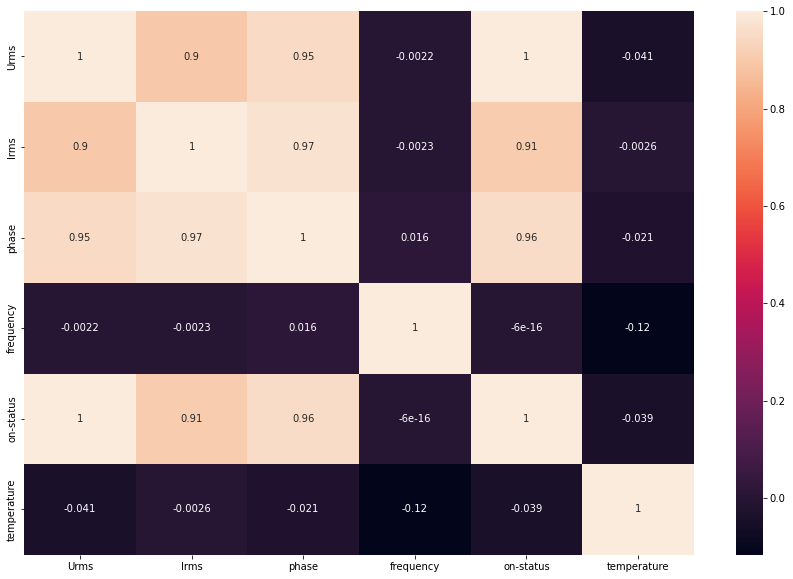

In [190]:
corr = df_H2O[H2O_features].corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels = corr.columns.values,
           yticklabels=corr.columns.values, annot = True)
plt.show()

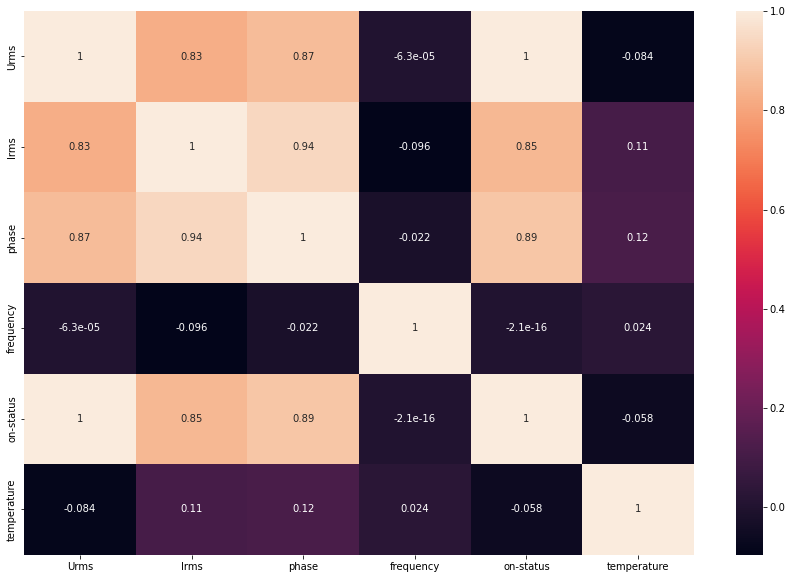

In [191]:
corr = df_starch_05[starch05_features].corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels = corr.columns.values,
           yticklabels=corr.columns.values, annot = True)
plt.show()

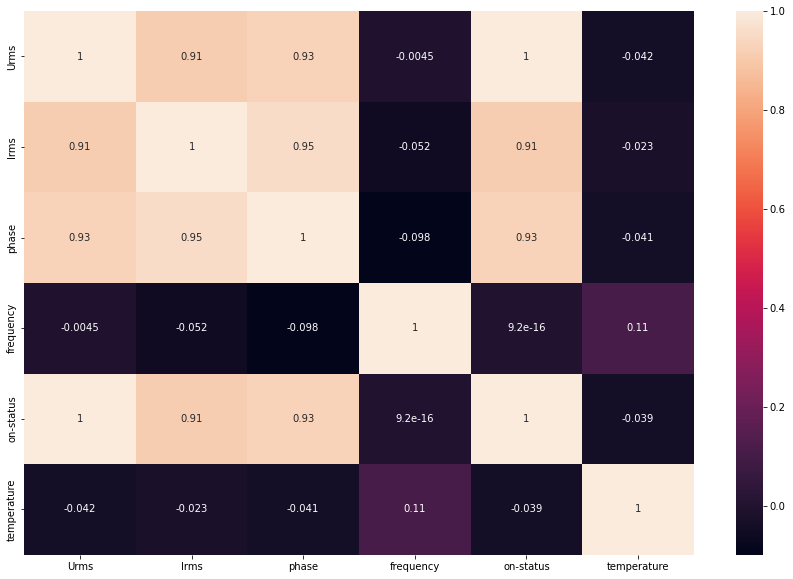

In [192]:
corr = df_starch_10[starch10_features].corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels = corr.columns.values,
           yticklabels=corr.columns.values, annot = True)
plt.show()

As we want to include the concentration feature, we need to combine the datasets

### PCA

In order to include concentrations of particles we cobine the datasets to one single df.

In [193]:
df = df_H2O.append(df_starch_05)
df = df.append(df_starch_10)
df = df.rename(columns={'on-status' : 'on_status'})
df = df[df.on_status != 0]
df.reset_index(drop=True, inplace=True)
df

,timestamp,Urms,Irms,phase,frequency,on_status,temperature,concentration,dTime
0,2021-06-21 14:25:38.826308,25026.0,7855.0,9241.0,2007,1,10.20,0.0,7.150793
1,2021-06-21 14:25:45.849108,25033.0,7856.0,9242.0,2007,1,10.19,0.0,7.022800
2,2021-06-21 14:25:52.887380,25035.0,7857.0,9242.0,2007,1,10.18,0.0,7.038272
3,2021-06-21 14:25:59.910584,25037.0,7859.0,9244.0,2007,1,10.16,0.0,7.023204
4,2021-06-21 14:26:06.949062,25038.0,7860.0,9243.0,2007,1,10.16,0.0,7.038478
...,...,...,...,...,...,...,...,...,...
710,2021-06-24 14:00:00.917445,24778.0,4975.0,8341.0,2207,1,10.07,1.0,7.149624
711,2021-06-24 14:00:07.941670,24782.0,4969.0,8351.0,2207,1,10.06,1.0,7.024225
712,2021-06-24 14:00:14.980324,24784.0,4970.0,8356.0,2207,1,10.07,1.0,7.038654
713,2021-06-24 14:00:22.002955,24785.0,4970.0,8362.0,2207,1,10.03,1.0,7.022631


In [194]:
from sklearn.preprocessing import StandardScaler
#Declaration of the features 

x_1 = df[features_PCA].copy()

# Define the scaler 
scaler_PCA = StandardScaler().fit(x_1)
# Scale the dataset
x_1 = pd.DataFrame(scaler_PCA.transform(x_1), columns=x_1.columns) #we need a df instead of an array for further processing
x_1

,Urms,Irms,phase,frequency,concentration
0,0.824796,-1.137322,-1.068090,-2.725436,-1.041708
1,0.833655,-1.137111,-1.067460,-2.725436,-1.041708
2,0.836187,-1.136901,-1.067460,-2.725436,-1.041708
3,0.838718,-1.136480,-1.066199,-2.725436,-1.041708
4,0.839984,-1.136270,-1.066830,-2.725436,-1.041708
...,...,...,...,...,...
710,0.510914,-1.743364,-1.635201,2.631778,1.400329
711,0.515977,-1.744627,-1.628899,2.631778,1.400329
712,0.518508,-1.744417,-1.625749,2.631778,1.400329
713,0.519774,-1.744417,-1.621968,2.631778,1.400329


In [195]:
#Declaration of the concentration as target 
y_1 = df['concentration'].copy()

y_1

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
710    1.0
711    1.0
712    1.0
713    1.0
714    1.0
Name: concentration, Length: 715, dtype: float64

In [196]:
from sklearn.decomposition import PCA
n_components = 5
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(x_1)
#principalDf = pd.DataFrame(data = principalComponents
#             , columns = ['principal component 1', 'principal component 2', 'principal component 3', ])
#principalDf
pca.get_covariance()

array([[ 1.00140056, -0.65396688, -0.86556858, -0.11524836, -0.02886465],
       [-0.65396688,  1.00140056,  0.66660845, -0.13372334, -0.21462771],
       [-0.86556858,  0.66660845,  1.00140056, -0.04117377,  0.12440355],
       [-0.11524836, -0.13372334, -0.04117377,  1.00140056,  0.042764  ],
       [-0.02886465, -0.21462771,  0.12440355,  0.042764  ,  1.00140056]])

In [197]:
explained_variance=pca.explained_variance_ratio_
explained_variance

array([0.49218765, 0.22860781, 0.19602695, 0.06009016, 0.02308743])

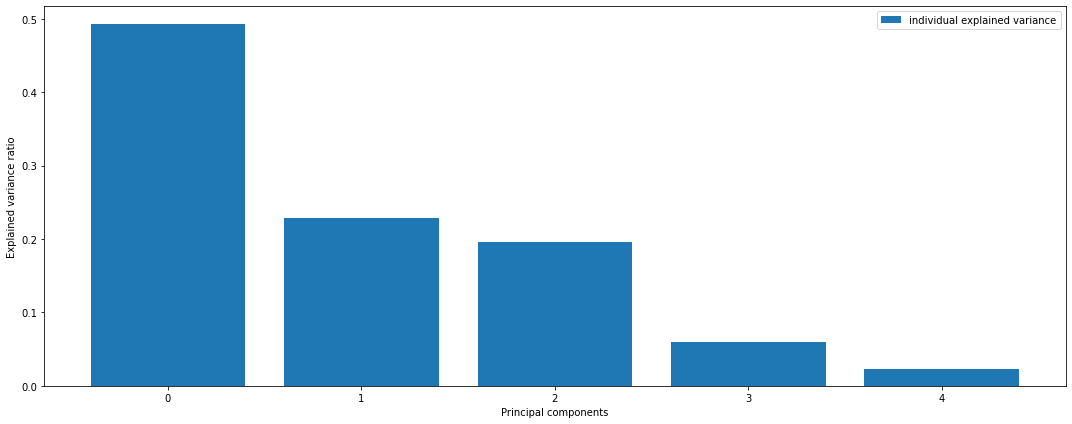

In [198]:
plt.figure(figsize=(15, 6))

plt.bar(range(n_components), explained_variance, alpha=1, align='center',
        label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [199]:
PCAcomp = pd.DataFrame(principalComponents)
PC_dict = {}
for idx,v in enumerate(PCAcomp):
    PC_dict[idx] = 'PC '+str(idx+1)
PCAcomp.rename(columns=PC_dict, inplace=True)
PCAcomp['concentration'] = y_1.values
PCAcomp

,PC 1,PC 2,PC 3,PC 4,PC 5,concentration
0,-1.667880,-2.290122,1.538693,1.040377,0.388996,0.0
1,-1.672641,-2.291504,1.539565,1.036985,0.382509,0.0
2,-1.674027,-2.291966,1.539786,1.035840,0.380789,0.0
3,-1.674548,-2.292313,1.540150,1.034929,0.378178,0.0
4,-1.675560,-2.292660,1.540179,1.034073,0.377772,0.0
...,...,...,...,...,...,...
710,-2.298142,2.726511,-1.331491,-0.231559,0.565333,1.0
711,-2.298069,2.726924,-1.330209,-0.230513,0.557332,1.0
712,-2.297577,2.726895,-1.329605,-0.230655,0.553363,1.0
713,-2.296073,2.727212,-1.329030,-0.229942,0.549801,1.0


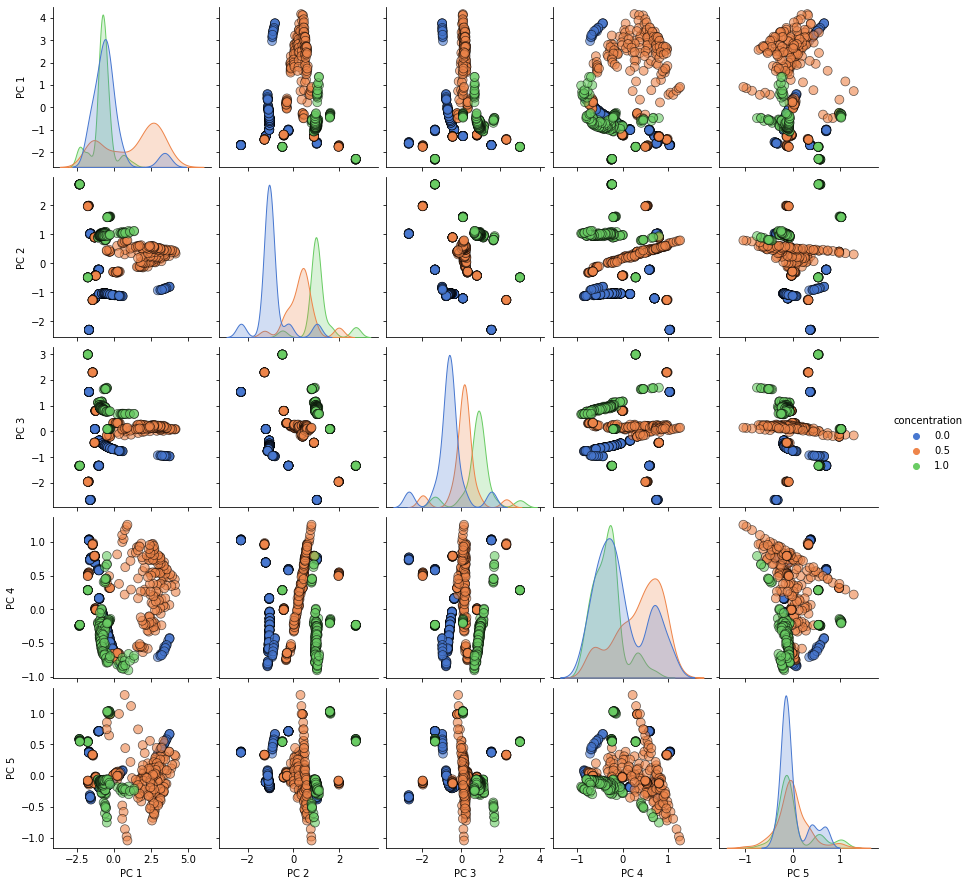

In [200]:
fig0 = sns.pairplot(PCAcomp, hue='concentration', palette = 'muted', plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'}) 
plt.show(fig0)

### Effect of features on the principle components

The components_ attribute provides principal axes in the feature space, representing the directions of maximum variance in the data. 

This means, we can see influence on each of the components by features. Reference: Ostwald Prasad


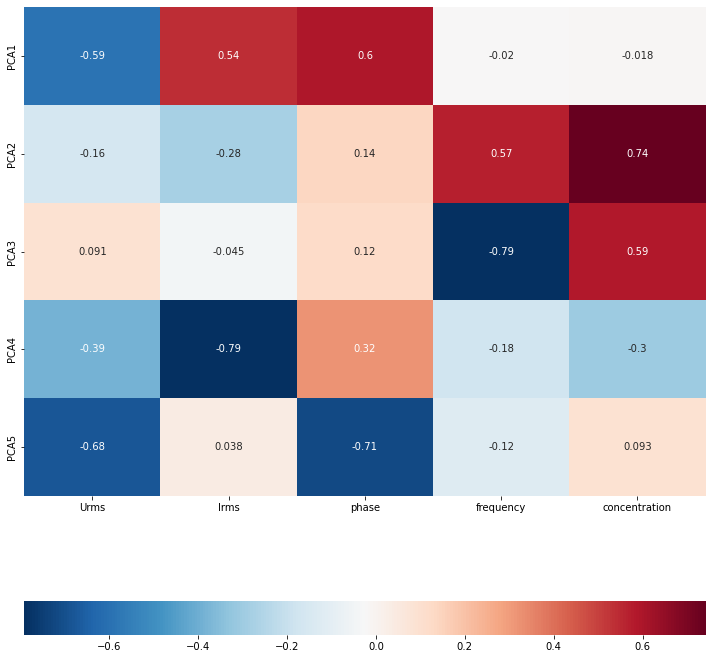

In [201]:
plt.figure(figsize=(10, 10))
sns.heatmap(pca.components_,
                 cmap='RdBu_r',
                 yticklabels=[ "PCA"+str(x) for x in range(1,pca.n_components_+1)],
                 xticklabels=list(x_1.columns),
                 annot= True,
                 cbar_kws={"orientation": "horizontal"})
plt.tight_layout()
plt.show()

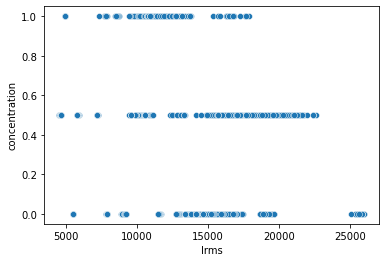

In [202]:
sns.scatterplot(data=df, x="Irms", y="concentration")
plt.show()

### Correlation combined DF

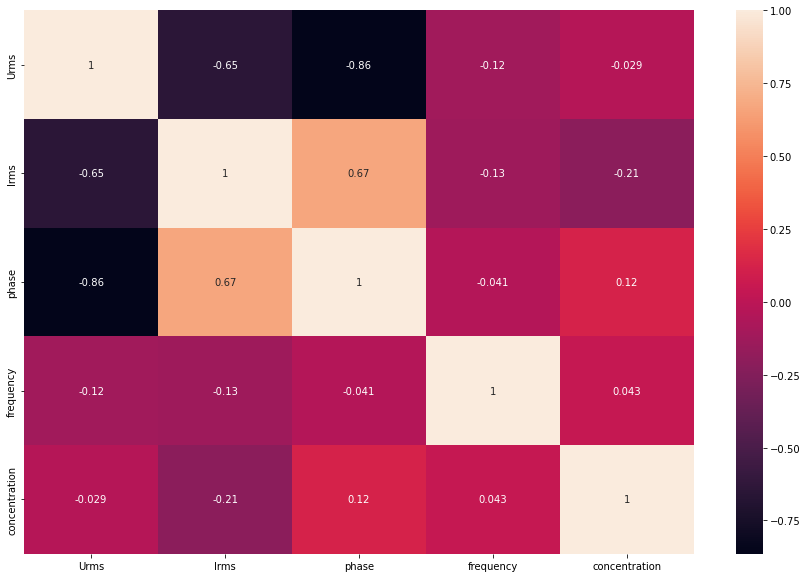

In [203]:
corr = df[features_PCA].corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels = corr.columns.values,
           yticklabels=corr.columns.values, annot = True)
plt.show()

### Decision Tree Classifier

In [204]:
features_dt = ['Urms', 'Irms', 'phase', 'frequency']
x1_dt = df[features_dt].copy()
x1_dt

,Urms,Irms,phase,frequency
0,25026.0,7855.0,9241.0,2007
1,25033.0,7856.0,9242.0,2007
2,25035.0,7857.0,9242.0,2007
3,25037.0,7859.0,9244.0,2007
4,25038.0,7860.0,9243.0,2007
...,...,...,...,...
710,24778.0,4975.0,8341.0,2207
711,24782.0,4969.0,8351.0,2207
712,24784.0,4970.0,8356.0,2207
713,24785.0,4970.0,8362.0,2207


In [205]:
categories_str = ['0 g/L', '0.5 g/L', '1 g/L']
categories = {0 : '0 g/L', 0.5 : '0.5 g/L', 1 : '1 g/L'}
y_1_cat = y_1.replace(categories)
y_1_cat

0      0 g/L
1      0 g/L
2      0 g/L
3      0 g/L
4      0 g/L
       ...  
710    1 g/L
711    1 g/L
712    1 g/L
713    1 g/L
714    1 g/L
Name: concentration, Length: 715, dtype: object

In [206]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cnt = 1
# split()  method generate indices to split data into training and test set.
for train_index, test_index in kf.split(x1_dt, y_1_cat):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt+=1
    
# Note that: 
# cross_val_score() parameter 'cv' will by default use StratifiedKFold spliting strategy if we just specify value of number of folds. 
# So you can bypass above step and just specify cv= 5 in cross_val_score() function

Fold:1, Train set: 643, Test set:72
Fold:2, Train set: 643, Test set:72
Fold:3, Train set: 643, Test set:72
Fold:4, Train set: 643, Test set:72
Fold:5, Train set: 643, Test set:72
Fold:6, Train set: 644, Test set:71
Fold:7, Train set: 644, Test set:71
Fold:8, Train set: 644, Test set:71
Fold:9, Train set: 644, Test set:71
Fold:10, Train set: 644, Test set:71


In [207]:
score = cross_val_score(tree.DecisionTreeClassifier(random_state= 42), x1_dt, y_1_cat, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')

Scores for each fold are: [0.95833333 0.98611111 0.98611111 0.97222222 0.98611111 1.
 0.95774648 1.         0.98591549 0.98591549]
Average score: 0.98


The crossvalidation shows that the dataset is very homogeneous, without notable outliers. If there were notable outlieres the different splits of train and test data would result in vastly differing accuracy scores, depending on whether the outlier would be included in the training or test data. Now we will test for the optimal Tree depth:

In [208]:
max_depth = [1,2,3,4,5,6,7,8,9,10]

for val in max_depth:
    score = cross_val_score(tree.DecisionTreeClassifier(max_depth= val, random_state= 42), x1_dt, y_1_cat, cv= kf, scoring="accuracy")
    print(f'Average score({val}): {"{:.3f}".format(score.mean())}')

Average score(1): 0.596
Average score(2): 0.771
Average score(3): 0.846
Average score(4): 0.943
Average score(5): 0.965
Average score(6): 0.975
Average score(7): 0.982
Average score(8): 0.982
Average score(9): 0.982
Average score(10): 0.982


A tree depth of 6 is a good balance between depth and accuracy of prediction.

In [209]:
x_train,x_test,y_train,y_test = train_test_split(x1_dt,y_1_cat,test_size=0.33, random_state=42)

classifier_concentration = DecisionTreeClassifier(max_leaf_nodes=6,random_state=0)
classifier_concentration.fit(x_train,y_train)

DecisionTreeClassifier(max_leaf_nodes=6, random_state=0)

In [210]:
y_predicted = classifier_concentration.predict(x_test)
np.unique(y_predicted)

array(['0 g/L', '0.5 g/L', '1 g/L'], dtype=object)

In [211]:
# Model performance on training set
y_pred_train =classifier_concentration.predict(x_train)

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

accuracy = metrics.accuracy_score(y_train, y_pred_train)
print("Accuracy: {:.2f}".format(accuracy))
cm=confusion_matrix(y_train,y_pred_train)
print('Confusion Matrix: \n', cm)
print(classification_report(y_train, y_pred_train, target_names=categories_str))

Accuracy: 0.89
Confusion Matrix: 
 [[161  31   0]
 [  1 156   0]
 [  5  16 109]]
              precision    recall  f1-score   support

       0 g/L       0.96      0.84      0.90       192
     0.5 g/L       0.77      0.99      0.87       157
       1 g/L       1.00      0.84      0.91       130

    accuracy                           0.89       479
   macro avg       0.91      0.89      0.89       479
weighted avg       0.91      0.89      0.89       479



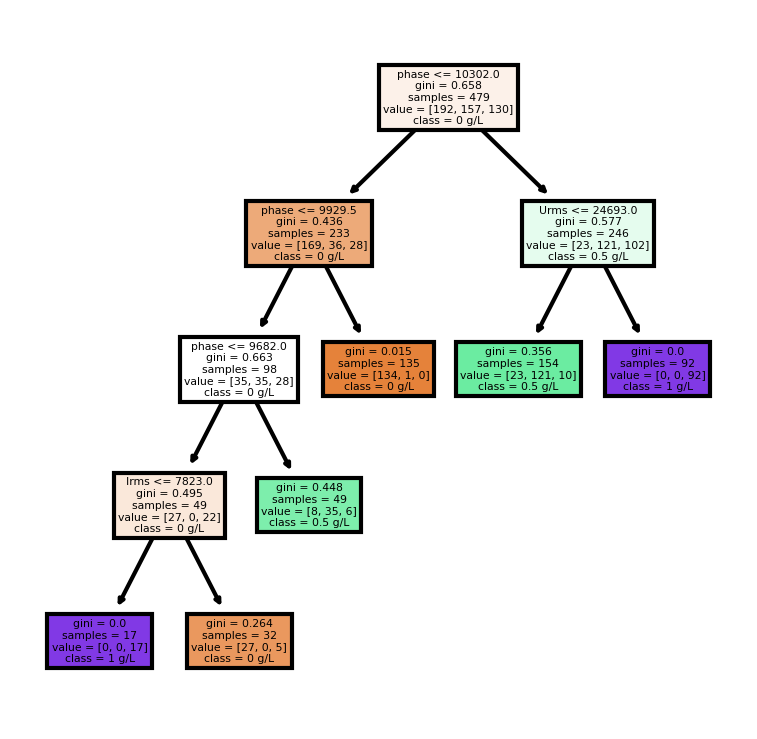

In [212]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (3,3), dpi=300)
tree.plot_tree(classifier_concentration,
               feature_names = features_dt, 
               class_names=categories_str,
               filled = True);
plt.show()

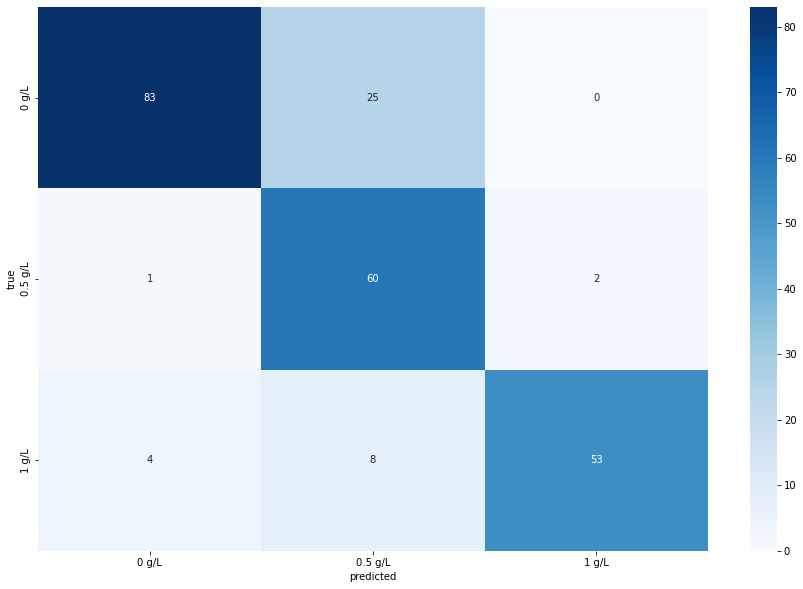

In [213]:
cf_matrix = confusion_matrix(y_test, y_predicted, labels= categories_str )
plt.subplots(figsize=(15,10))
sns.heatmap(cf_matrix, annot=True, xticklabels=categories_str, yticklabels=categories_str, fmt='', cmap='Blues')
plt.xlabel("predicted") 
plt.ylabel("true")
plt.show()

### SVM

#### Classification

In [214]:
from sklearn import svm, datasets
from sklearn.svm import SVC
import sklearn.model_selection as model_selection
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [215]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(x1_dt, y_1_cat, test_size=0.20)


svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)
y_pred_lin = svclassifier.predict(X_test)
print("SVM - linear:")
print(accuracy_score(y_test,y_pred_lin))

svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, y_train)
y_pred_rbf = svclassifier.predict(X_test)
print("SVM - rbf:")
print(accuracy_score(y_test,y_pred_rbf))

### Regression

#### OLS

In [216]:
from sklearn import linear_model
# fit a regression model to the data: ols .. ordinary least square model

model = smf.ols(formula = "concentration ~ Urms + Irms + phase", data = df).fit()

In [217]:
#info about model
model.summary()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.176   
Dependent Variable: concentration    AIC:                618.8282
Date:               2022-07-21 11:56 BIC:                637.1173
No. Observations:   715              Log-Likelihood:     -305.41 
Df Model:           3                F-statistic:        51.87   
Df Residuals:       711              Prob (F-statistic): 2.53e-30
R-squared:          0.180            Scale:              0.13835 
------------------------------------------------------------------
              Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
------------------------------------------------------------------
Intercept    -2.6125    1.0386   -2.5154  0.0121  -4.6516  -0.5734
Urms          0.0001    0.0000    2.2215  0.0266   0.0000   0.0001
Irms         -0.0000    0.0000  -11.0037  0.0000  -0.0001  -0.0000
phase         0.0002    0.0000    8.5290  0.0000   0.0001   0.0002
-----------------------------------------------------------------
Omnibus:              281.903      Durbin-Watson:         0.050  
Prob(Omnibus):        0.000        Jarque-Bera (JB):      54.884 
Skew:                 0.393        Prob(JB):              0.000  
Kurtosis:             1.894        Condition No.:         2232534
=================================================================
* The condition number is large (2e+06). This might indicate
strong multicollinearity or other numerical problems.
"""

#### SVM

In [218]:
features_SVM = ['Urms', 'Irms', 'phase', 'frequency']
target_SVM = ['concentration']
X = df[features_SVM].copy()
X

,Urms,Irms,phase,frequency
0,25026.0,7855.0,9241.0,2007
1,25033.0,7856.0,9242.0,2007
2,25035.0,7857.0,9242.0,2007
3,25037.0,7859.0,9244.0,2007
4,25038.0,7860.0,9243.0,2007
...,...,...,...,...
710,24778.0,4975.0,8341.0,2207
711,24782.0,4969.0,8351.0,2207
712,24784.0,4970.0,8356.0,2207
713,24785.0,4970.0,8362.0,2207


In [219]:
y = df[target_SVM].copy()
y

,concentration
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
710,1.0
711,1.0
712,1.0
713,1.0


In [220]:
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.40, random_state=42)

In [221]:
from sklearn.svm import SVR
# most important SVR parameter is Kernel type. It can be #linear,polynomial or gaussian SVR. We have a non-linear condition #so we can select polynomial or gaussian but here we select RBF(a #gaussian type) kernel.
regressor = SVR(kernel='poly')
regressor.fit(X_train,y_train)

SVR(kernel='poly')

In [222]:
y_pred = regressor.predict(X_test)
y_pred

array([-6.22924960e-01,  1.25776616e+00, -4.09875473e-01,  2.98944773e-01,
       -1.59087824e-01,  9.38465538e-02,  3.01154525e-01,  1.55437366e-01,
       -9.45845471e-01, -1.04317895e-02,  3.50849723e-01, -2.99964761e-01,
        1.69044263e-02, -2.24642084e-01, -1.05295000e+00, -3.87678106e-01,
       -1.98445353e-01, -5.11307207e-01,  1.37123271e+00,  5.90424700e-02,
       -6.77767649e-01, -1.01971770e+00, -2.02108454e-01, -1.64738095e-01,
       -3.55648874e-01, -9.87309718e-01, -9.29578243e-01, -8.84701860e-01,
       -2.01225564e-01, -1.88835266e-01,  8.99880463e-02, -4.79248643e-01,
       -4.73219490e-02, -9.67370211e-02, -2.34613674e-01, -1.47668741e-01,
       -9.52223104e-01,  8.87566384e-02, -1.34488981e+00, -4.47060716e-02,
       -9.76729465e-01, -1.83151133e-01, -2.03798839e-01, -3.26012223e-01,
       -1.07402650e+00, -5.78423064e-01,  1.44143754e-01,  2.21273255e-01,
       -1.11620513e+00,  2.22792700e-02, -3.60365157e-01, -2.22409624e-01,
       -1.02878047e-01, -

In [223]:
from sklearn.metrics import r2_score,mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

0.9028374564518595

#### NN

In [251]:
from keras import layers, optimizers, regularizers
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.models import Sequential
#from keras.optimizers import Adam

#from kt_utils import *
import keras.backend as K

In [252]:
x1_dt

,Urms,Irms,phase,frequency
0,25026.0,7855.0,9241.0,2007
1,25033.0,7856.0,9242.0,2007
2,25035.0,7857.0,9242.0,2007
3,25037.0,7859.0,9244.0,2007
4,25038.0,7860.0,9243.0,2007
...,...,...,...,...
710,24778.0,4975.0,8341.0,2207
711,24782.0,4969.0,8351.0,2207
712,24784.0,4970.0,8356.0,2207
713,24785.0,4970.0,8362.0,2207


In [253]:
y_1_int = df['concentration'].copy()
y_1_int = y_1_int.apply(lambda x: int(x*2))

In [254]:
from sklearn import preprocessing, model_selection 

x1_dt_norm = preprocessing.normalize(x1_dt, axis = 0)

X_train,X_test,Y_train,Y_test = model_selection.train_test_split(x1_dt, y_1, test_size=0.20)
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)


(572, 4) (572,) (143, 4) (143,)


A simple sequential NN with dropout to prevent overfitting

In [260]:
concmod1 = Sequential()
# layer 1
concmod1.add(Dense(50, input_dim=4, activation='relu', name='fc0',kernel_regularizer=regularizers.l2(0.01)))
concmod1.add(BatchNormalization(momentum=0.99, epsilon=0.001))
#layer 2
concmod1.add(Dense(100, name='fc1',bias_initializer='zeros'))
concmod1.add(BatchNormalization(momentum=0.99, epsilon=0.001))
concmod1.add(Activation('tanh'))
concmod1.add(Dropout(0.5))
#layer 3
concmod1.add(Dense(500, name='fc2',bias_initializer='zeros'))
concmod1.add(BatchNormalization(momentum=0.99, epsilon=0.001))
concmod1.add(Activation('tanh'))
concmod1.add(Dropout(0.5))
#layer 3
concmod1.add(Dense(500, name='fc3',bias_initializer='zeros'))
concmod1.add(BatchNormalization(momentum=0.99, epsilon=0.001))
concmod1.add(Activation('tanh'))
concmod1.add(Dropout(0.5))
#layer 4
concmod1.add(Dense(3, name='fc4',bias_initializer='zeros')) #last layer needs the same amount of neuron as the amount of classes you want to categorize
concmod1.add(BatchNormalization(momentum=0.99, epsilon=0.001))
concmod1.add(Activation('softmax'))

In [261]:
concmod1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc0 (Dense)                 (None, 50)                250       
                                                                 
 batch_normalization_36 (Bat  (None, 50)               200       
 chNormalization)                                                
                                                                 
 fc1 (Dense)                 (None, 100)               5100      
                                                                 
 batch_normalization_37 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 activation_27 (Activation)  (None, 100)               0         
                                                                 
 dropout_19 (Dropout)        (None, 100)              

from keras_visualizer import visualizer 
visualizer(concmod1, format='png', view=True)

#### Why Dropout Regularization
Dropout is a regularization technique for neural network models proposed by Srivastava, et al. in their 2014 paper.

Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass.

As a neural network learns, neuron weights settle into their context within the network. Weights of neurons are tuned for specific features providing some specialization. Neighboring neurons become to rely on this specialization, which if taken too far can result in a fragile model too specialized to the training data. This reliant on context for a neuron during training is referred to complex co-adaptations.

You can imagine that if neurons are randomly dropped out of the network during training, that other neurons will have to step in and handle the representation required to make predictions for the missing neurons. This is believed to result in multiple independent internal representations being learned by the network.

The effect is that the network becomes less sensitive to the specific weights of neurons. This in turn results in a network that is capable of better generalization and is less likely to overfit the training data.

In [262]:
concmod1.compile(optimizer = 'adam', loss = "sparse_categorical_crossentropy", metrics = ["sparse_categorical_accuracy"])

In [263]:
concmod1.fit(x = X_train, y = Y_train, epochs = 200, verbose=1, batch_size = 64, validation_data=(X_test, Y_test), shuffle=True, class_weight=None)

Epoch 1/200
9/9 [==============================] - 1s 19ms/step - loss: 1.1383 - sparse_categorical_accuracy: 0.3374 - val_loss: 2.9981 - val_sparse_categorical_accuracy: 0.2867
Epoch 2/200
9/9 [==============================] - 0s 5ms/step - loss: 0.9817 - sparse_categorical_accuracy: 0.4563 - val_loss: 2.6140 - val_sparse_categorical_accuracy: 0.2867
Epoch 3/200
9/9 [==============================] - 0s 5ms/step - loss: 0.9371 - sparse_categorical_accuracy: 0.4563 - val_loss: 1.3948 - val_sparse_categorical_accuracy: 0.2867
Epoch 4/200
9/9 [==============================] - 0s 4ms/step - loss: 0.9150 - sparse_categorical_accuracy: 0.4860 - val_loss: 1.1873 - val_sparse_categorical_accuracy: 0.2867
Epoch 5/200
9/9 [==============================] - 0s 5ms/step - loss: 0.8690 - sparse_categorical_accuracy: 0.4878 - val_loss: 0.9947 - val_sparse_categorical_accuracy: 0.4056
Epoch 6/200
9/9 [==============================] - 0s 5ms/step - loss: 0.8333 - sparse_categorical_accuracy: 0.515

In [250]:
preds = concmod1.evaluate(x = X_test, y = Y_test)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

5/5 [==============================] - 0s 806us/step - loss: 0.4400 - sparse_categorical_accuracy: 0.5035

Loss = 0.4399545192718506
Test Accuracy = 0.503496527671814


In [233]:
Y_pred = concmod1.predict(X_test)
Y_pred_index = np.argmax(Y_pred, axis = 1)
Y_pred_index = pd.Series(Y_pred_index)
Y_pred_index

5/5 [==============================] - 0s 645us/step


0      0
1      0
2      0
3      0
4      0
      ..
138    0
139    0
140    0
141    1
142    0
Length: 143, dtype: int64

In [236]:
Y_test = Y_test.apply(lambda x: x*2)
Y_test

674    2.0
684    2.0
461    1.0
628    2.0
558    2.0
      ... 
429    1.0
425    1.0
19     0.0
552    2.0
376    1.0
Name: concentration, Length: 143, dtype: float64

In [ ]:
categories_str = ['0 g/L', '0.5 g/L', '1 g/L']
categories = {0 : '0 g/L', 0.5 : '0.5 g/L', 1 : '1 g/L'}
y_1_cat = y_1.replace(categories)
y_1_cat

In [241]:
cf_matrix = confusion_matrix(Y_test, Y_pred_index, labels=[0,1,2], normalize='pred' )
#rounded_y_pred = np.argmax (y_pred, axis = 1)
#Y_test=np.argmax(Y_test, axis=1)
cf_matrix

array([[0.43939394, 0.        , 0.        ],
       [0.31818182, 0.        , 0.        ],
       [0.24242424, 1.        , 0.        ]])

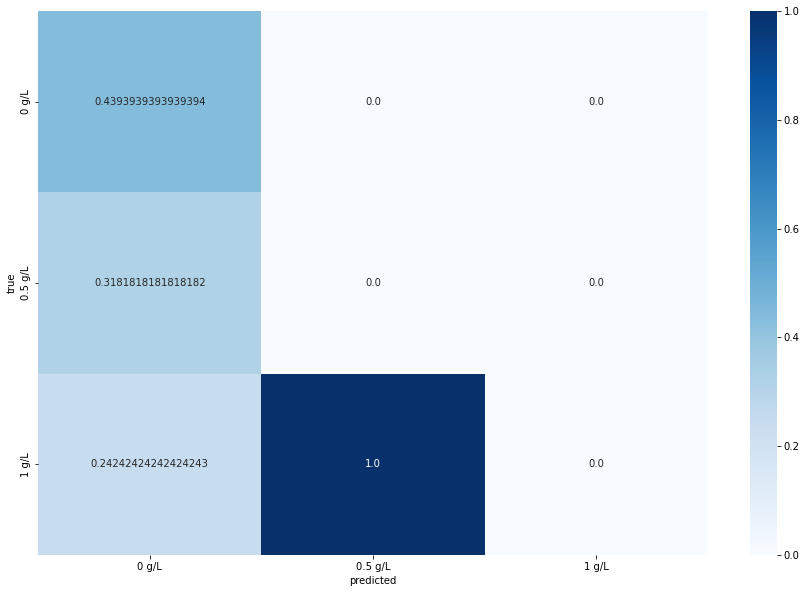

In [240]:
plt.subplots(figsize=(15,10))
sns.heatmap(cf_matrix, annot=True, xticklabels=categories_str, yticklabels=categories_str, fmt='', cmap='Blues')
plt.xlabel("predicted") 
plt.ylabel("true")
plt.show()

In [ ]:
cf_matrix_NN1 = confusion_matrix(Y_test, Y_pred[:,0], labels='pred')
group_names = ['True Bad','False Good','False Bad','True Good']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_NN1.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_NN1.flatten()/np.sum(cf_matrix_NN1)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_NN1, annot=labels, fmt='', cmap='Blues')

ValueError: continuous is not supported